## Logistic regression and regularization
### Nerd Club's Intro to ML, part II
Welcome to Machine Learning  with Harvard Program in Neuroscience's Comp Club! This notebook will introduce you to logistic regression with regularization. It is designed to be standalone.

This exercise is heavily influenced by Andrew Ng's [Machine Learning course on Coursera](https://www.coursera.org/learn/machine-learning). If this is helpful, go check that out!

By: Jim Bohnslav

## Logistic regression: basics
Logistic regression is a simple binary, linear classifier that takes some inputs and classifies them into 1s and 0s. As Stephen covered, logistic regression is basically linear regression, with the output passed through a nonlinearity that turns it into a probability. It has a different cost function than linear regression.

In [1]:
from scipy import io
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt
import helpers

In [2]:
mat = io.loadmat('data_structure_ANM210861_20130701.mat',squeeze_me=True,struct_as_record=False)
t = np.arange(0,29)/19531.25*1000
neurons = mat['obj'].eventSeriesHash.value
mat2 = io.loadmat('data_structure_ANM210861_20130702.mat',squeeze_me=True,struct_as_record=False)
neurons = np.concatenate((neurons, mat2['obj'].eventSeriesHash.value))
m_ses1 = len(mat['obj'].eventSeriesHash.value)
m = neurons.shape[0]

ses_ids = np.zeros((m,1),dtype='uint8')
ses_ids[m_ses1:] = 1

ses_starts = np.zeros((m,1),dtype='float64')
ses_ends = np.zeros((m,1),dtype='float64')
ses_starts[0:m_ses1] = mat['obj'].timeSeriesArrayHash.value.time[0]
ses_starts[m_ses1:] = mat2['obj'].timeSeriesArrayHash.value.time[0]
ses_ends[0:m_ses1] = mat['obj'].timeSeriesArrayHash.value.time[-1]
ses_ends[m_ses1:] = mat2['obj'].timeSeriesArrayHash.value.time[-1]

In [3]:
spike_avgs = np.zeros((m,29),dtype='float64')
for i in range(m):
    spike_avgs[i,:]=np.mean(neurons[i].waveforms,axis=0)

In [246]:
def calculate_peak_to_trough_ratio(avg_waveform):
    trough_val = np.min(avg_waveform)
    trough_loc = np.argmin(avg_waveform)
    peak_val = np.max(avg_waveform[trough_loc:])
    return(np.abs(peak_val/trough_val))

def calculate_peak_to_trough_interval(t,avg_waveform):
    trough_loc = np.argmin(avg_waveform)
    peak_loc = np.argmax(avg_waveform[trough_loc:])+trough_loc
    return(t[peak_loc]-t[trough_loc])

# defined according to Niell and Stryker 2008
def calculate_post_trough_slope(t, avg_waveform):
    trough_loc = np.argmin(avg_waveform)
    # calculate slope around 0.5ms after trough
    end = np.min([trough_loc+15, len(avg_waveform)])
    locs = np.arange(trough_loc+5,end)
    # locs = np.arange(19,25)
    local_V = avg_waveform[locs]
    slope, __, __, __, __ = linregress(t[locs], local_V)
    # slope = (avg_waveform[trough_loc+11]-avg_waveform[trough_loc+9]) /(t[trough_loc+11]-t[trough_loc+9])
    return(slope)

def get_celltype(neuron):
    celltype = np.nan
    if neuron.cellType == 'FS':
        celltype = 1
    elif neuron.cellType == 'pyramidal':
        celltype = 0
    else:
        celltype = 2
    return(celltype)

def get_mean_spikerate(neuron,ses_start,ses_end):
    n_spikes = len(neuron.eventTimes)
    ses_length = ses_end-ses_start
    return(n_spikes/ses_length)
    
def get_neuron_features(neurons,t,ses_starts,ses_ends):
    mean_waveforms = np.zeros((m,29), dtype='float64')
    cell_types = np.zeros((m,1),dtype='uint8')
    peak_to_trough_ratios = np.zeros((m,1),dtype='float64')
    peak_to_trough_intervals = np.zeros((m,1),dtype='float64')
    post_trough_slopes = np.zeros((m,1),dtype='float64')
    mean_spikerates = np.zeros((m,1),dtype='float64')
    for i in range(0,len(neurons)):
        neuron = neurons[i]
        mean_waveform = np.mean(neuron.waveforms,axis=0)
        mean_waveforms[i,:] = mean_waveform
        cell_types[i] = get_celltype(neuron)
        peak_to_trough_ratios[i] = calculate_peak_to_trough_ratio(mean_waveform)
        peak_to_trough_intervals[i] =  calculate_peak_to_trough_interval(t,mean_waveform)
        post_trough_slopes[i] = calculate_post_trough_slope(t,mean_waveform)
        mean_spikerates[i] = get_mean_spikerate(neuron,ses_starts[i],ses_ends[i])
    
    X = np.concatenate((peak_to_trough_ratios.T,peak_to_trough_intervals.T,post_trough_slopes.T,mean_spikerates.T),
                      axis=0)
    Y = np.squeeze(np.uint8(cell_types==0).T)
    
    return(X,Y,mean_waveforms, cell_types, peak_to_trough_ratios, peak_to_trough_intervals,
          post_trough_slopes,mean_spikerates)
    

In [163]:
np.squeeze(Y).shape

(46,)

In [247]:
features = get_neuron_features(neurons,t,ses_starts,ses_ends)
X,Y,mean_waveforms, cell_types, peak_to_trough_ratios, peak_to_trough_intervals,post_trough_slopes,mean_spikerates = features

c:\programdata\anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\programdata\anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [248]:
# matplotlib has the amazing feature that it lets you style all subsequent figures the same
# https://matplotlib.org/devdocs/gallery/style_sheets/style_sheets_reference.html
# because I like http://fivethirtyeight.com, let's use their style.
plt.style.use('fivethirtyeight')
# get the default colors from fivethirtyeight stylesheet
colors = helpers.get_colors()

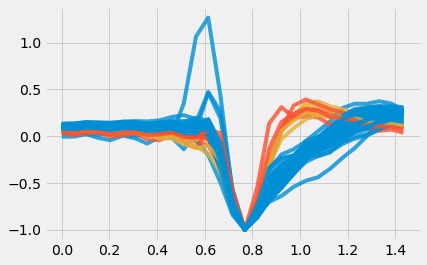

In [249]:
plt.figure()
for i in range(m):
    plt.plot(t,mean_waveforms[i,:]/-np.min(mean_waveforms[i,:]), c=colors[cell_types[i][0]],
            alpha=0.8)
plt.show()

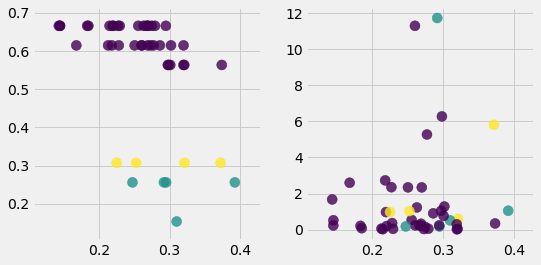

In [250]:
plt.figure(figsize=(8,4))
    
plt.subplot(121)
plt.scatter(peak_to_trough_ratios, peak_to_trough_intervals,c=cell_types,
           s=100,alpha=0.8)
ax2 = plt.subplot(122)
plt.scatter(peak_to_trough_ratios, mean_spikerates, c=cell_types,
           s=100,alpha=0.8)
plt.show()

In [31]:
def sigmoid(vector):
    g = 1/(1+np.exp(-vector))
    return(g)

In [45]:
def hypothesis(x, theta):
    h = sigmoid(np.dot(theta.T, x))
    return(h)

In [200]:
def binary_cross_entropy_cost(X,Y,theta,lamda):
    J = 0
    m = X.shape[1]
    for i in range(m):
        y_hat = hypothesis(X[:,i],theta)
        J+=-(Y[i]*np.log(y_hat) + (1-Y[i])*np.log(1-y_hat))
    
    regularization_term = 0
    for i in range(1,theta.shape[0]):
        regularization_term += theta[i]**2
        
    J = J*1/m + lamda/(2*m)*regularization_term
    
    return(J)

In [37]:
def binary_cross_entropy_cost_vectorized(X,Y,theta,lamda):
    pass

In [167]:
def calculate_gradient(X,Y,theta,lamda):
    m = X.shape[1]
    gradient = np.zeros(theta.shape,dtype='float64')
    
    for j in range(theta.shape[0]):
        for i in range(m):
            gradient[j]+= (hypothesis(X[:,i],theta)-Y[i])*X[j,i]
        gradient[j]/=m
        if j>0:
            gradient[j] += lamda/m*theta[j]
            
    return(gradient)

In [100]:
def calculate_gradient_vectorized(X,Y,theta,lamda=0.01):
    m = X.shape[1]
    A = sigmoid(np.dot(theta.T,X))
    dZ = A-Y
    gradient = 1/m*np.dot(X,dZ.T)
    temp = np.copy(theta)
    temp[0] = 0
    gradient+= lamda/m*temp
    return(gradient)

In [191]:
def initialize_theta(X):
    theta = np.zeros((X.shape[0]),dtype='float64')
    return(theta)

In [187]:
def model(X,Y,alpha=0.01,lamda=0.01,epochs=100):
    theta = initialize_theta(X)
    
    costs = np.zeros((epochs,1),dtype='float64')
    
    for epoch in range(epochs):
        theta-=alpha*calculate_gradient_vectorized(X,Y,theta,lamda)
        costs[epoch] = binary_cross_entropy_cost(X,Y,theta,lamda)
    
    return(theta,costs)

[ -4.92578853  -2.58147544  14.70043396   0.01608492  -0.06863801]


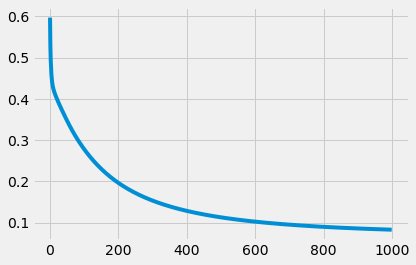

In [272]:
X1 = np.copy(X)
X1 = np.concatenate((np.ones((1,X1.shape[1])),X1))
theta, costs = model(X1,Y,alpha=1, epochs=1000, lamda=0.01)
print(theta)
plt.figure()
plt.plot(costs)
plt.show()

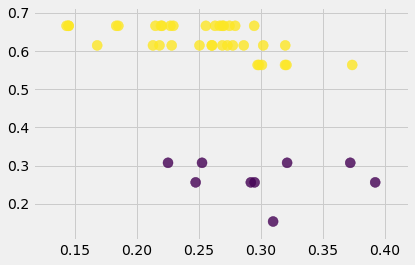

In [266]:
plt.figure()
y_hat = hypothesis(X1,theta)
plt.scatter(peak_to_trough_ratios, peak_to_trough_intervals,c=Y,
           s=100,alpha=0.8)
plt.show()

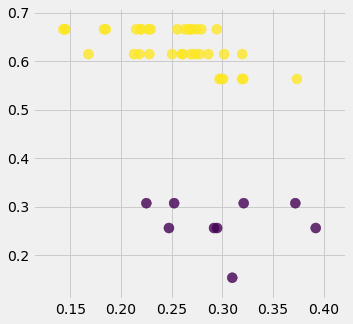

In [273]:
predicted = np.uint8(hypothesis(X1,theta)>0.5)
plt.figure(figsize=(5,5))
y_hat = hypothesis(X1,theta)
ax1 = plt.subplot(111)
ax1.scatter(peak_to_trough_ratios, peak_to_trough_intervals,c=predicted,
           s=100,alpha=0.8)
xlims = np.array(ax1.get_xlim())
x_1 = np.array([1,],dtype='float64')
plt.show()

In [264]:
theta

array([ -4.92578853,  -2.58147544,  14.70043396,   0.01608492,  -0.06863801])

In [259]:
X1.shape

(5, 46)

In [198]:
J = 0
m = X.shape[1]
for i in range(m):
    y_hat = hypothesis(X[:,i],theta)
    J+=-(Y[i]*np.log(y_hat) + (1-Y[i])*np.log(1-y_hat))

In [242]:
theta

array([ -1.63482777e+00,   1.86312865e-01,  -1.39942134e+00,
        -1.21920338e-03,   1.25016645e-01])